# Notebook 50 — Crypto: Short-Dated Risk, Volatility Instability, and Model Breakdown

This notebook uses the *preprocessed* BTC datasets produced by `scripts/pull_crypto_data.py`.
It focuses on diagnostics and stress-style risk estimates, **not** on trading signals.


## Parameters


In [ ]:
from __future__ import annotations

%matplotlib inline

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.gbm import simulate_gbm_paths
from src.risk_metrics import empirical_es, empirical_var

# Resolve repo root for relative paths
ROOT = Path.cwd()
if not (ROOT / "data").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# File paths
DAILY_PATH = ROOT / "data/processed/btc_daily.csv"
DAILY_FEATURES_PATH = ROOT / "data/processed/btc_features_daily.csv"
HOURLY_PATH = ROOT / "data/processed/btc_hourly.csv"
HOURLY_FEATURES_PATH = ROOT / "data/processed/btc_features_hourly.csv"

# Output directory for figures
FIG_DIR = ROOT / "figures/50_crypto_short_dated_options"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Date filters (set to None to keep full history)
DAILY_START = None
DAILY_END = None
HOURLY_START = None
HOURLY_END = None

# Rolling windows
DAILY_WINDOWS = (30, 90)  # days
HOURLY_WINDOWS = (168, 720)  # hours

# Monte Carlo settings
N_PATHS = 20000
SEED_BASE = 123

# VaR/ES settings
ALPHAS = (0.95, 0.99)

# Evaluation dates to sample
N_EVAL_DATES = 8

## Setup helpers


In [72]:
def savefig(fig, filename: str) -> None:
    path = FIG_DIR / filename
    fig.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()


def summary_stats(returns: pd.Series) -> dict[str, float]:
    returns = returns.dropna()
    return {
        "count": float(returns.shape[0]),
        "mean": float(returns.mean()),
        "std": float(returns.std()),
        "min": float(returns.min()),
        "max": float(returns.max()),
    }


def pick_eval_indices(valid_index: pd.Index, n: int) -> list[int]:
    if len(valid_index) == 0:
        return []
    idx = np.linspace(0, len(valid_index) - 1, num=min(n, len(valid_index))).astype(int)
    return valid_index[idx].tolist()


def simulate_var_es_gbm(
    sigma_annual: float,
    horizon_years: float,
    n_steps: int,
    n_paths: int,
    seed: int,
    alpha: float,
) -> tuple[float, float]:
    # Work in price space with S0=1, zero drift (conservative baseline)
    _, paths = simulate_gbm_paths(
        S0=1.0,
        mu=0.0,
        sigma=float(sigma_annual),
        T=float(horizon_years),
        n_steps=int(n_steps),
        n_paths=int(n_paths),
        seed=int(seed),
    )
    pnl = paths[:, -1] - 1.0
    var = empirical_var(pnl, alpha=alpha)
    es = empirical_es(pnl, alpha=alpha)
    return var, es


def horizon_pnl_samples(
    log_returns: pd.Series,
    end_idx: int,
    window: int,
    horizon: int,
) -> np.ndarray | None:
    hist = log_returns.iloc[:end_idx]
    if hist.shape[0] < window:
        return None
    hist_window = hist.iloc[-window:]
    if hist_window.shape[0] < horizon:
        return None
    agg = hist_window.rolling(horizon).sum().dropna()
    if agg.empty:
        return None
    return np.exp(agg.values) - 1.0

## 1) Setup & data integrity


In [73]:
daily = pd.read_csv(DAILY_FEATURES_PATH, parse_dates=["date"])
hourly = pd.read_csv(HOURLY_FEATURES_PATH, parse_dates=["timestamp"])

required_daily = {"date", "price", "ret_1d", "vol_7d", "vol_30d", "vol_90d"}
required_hourly = {"timestamp", "price", "ret_1h", "vol_24h", "vol_168h", "vol_720h"}

missing_daily = required_daily.difference(daily.columns)
missing_hourly = required_hourly.difference(hourly.columns)
assert not missing_daily, f"Missing daily columns: {missing_daily}"
assert not missing_hourly, f"Missing hourly columns: {missing_hourly}"

daily = daily.sort_values("date").drop_duplicates("date")
hourly = hourly.sort_values("timestamp").drop_duplicates("timestamp")

if DAILY_START:
    daily = daily[daily["date"] >= pd.to_datetime(DAILY_START)]
if DAILY_END:
    daily = daily[daily["date"] <= pd.to_datetime(DAILY_END)]
if HOURLY_START:
    hourly = hourly[hourly["timestamp"] >= pd.to_datetime(HOURLY_START)]
if HOURLY_END:
    hourly = hourly[hourly["timestamp"] <= pd.to_datetime(HOURLY_END)]

daily_stats = summary_stats(daily["ret_1d"])
hourly_stats = summary_stats(hourly["ret_1h"])

print("Daily range:", daily["date"].min().date(), "to", daily["date"].max().date())
print("Daily obs:", len(daily), "Return stats:", daily_stats)
print("Hourly range:", hourly["timestamp"].min(), "to", hourly["timestamp"].max())
print("Hourly obs:", len(hourly), "Return stats:", hourly_stats)

Daily range: 2017-08-17 to 2026-02-02
Daily obs: 3092 Return stats: {'count': 3091.0, 'mean': 0.0009382631252665057, 'std': 0.03605828198388262, 'min': -0.5026069427414592, 'max': 0.2029522152282802}
Hourly range: 2017-08-17 04:00:00+00:00 to 2026-02-02 13:00:00+00:00
Hourly obs: 74066 Return stats: {'count': 74065.0, 'mean': 3.90889353633089e-05, 'std': 0.00783839029141162, 'min': -0.2010332141747841, 'max': 0.1602803315414613}


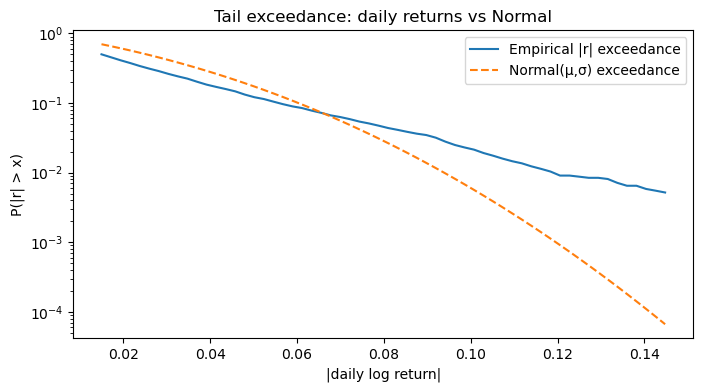

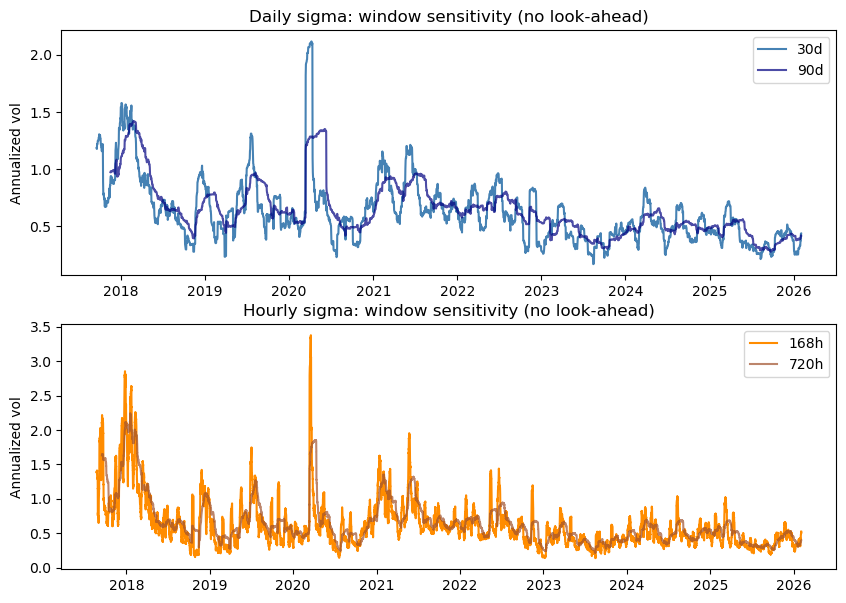

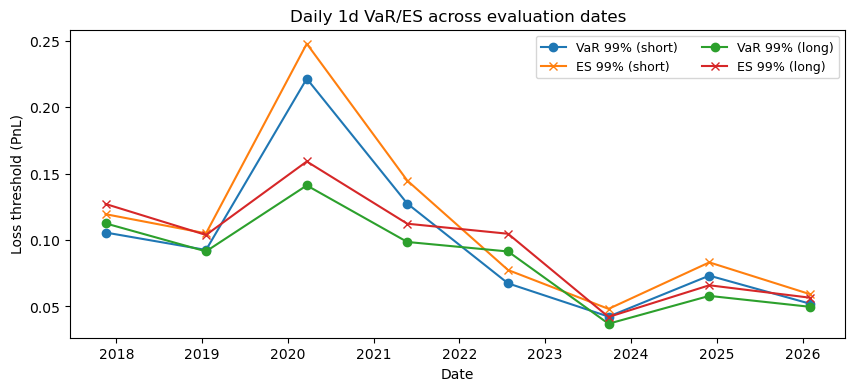

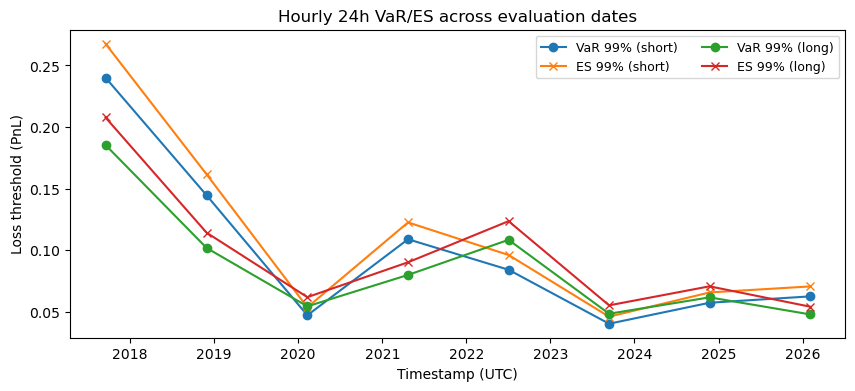

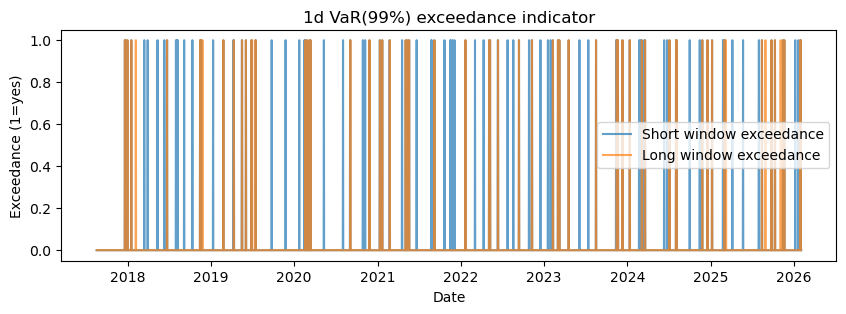

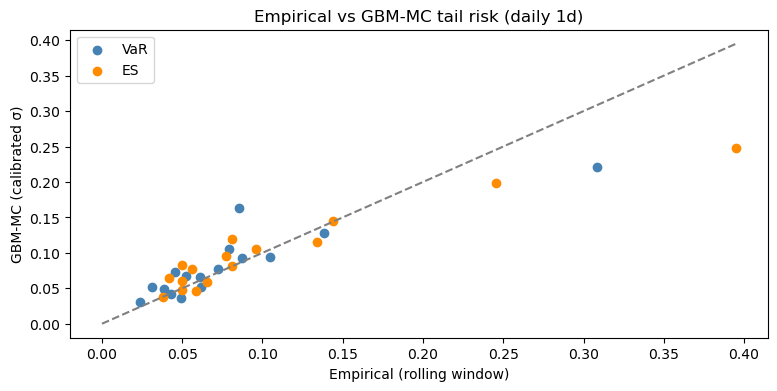

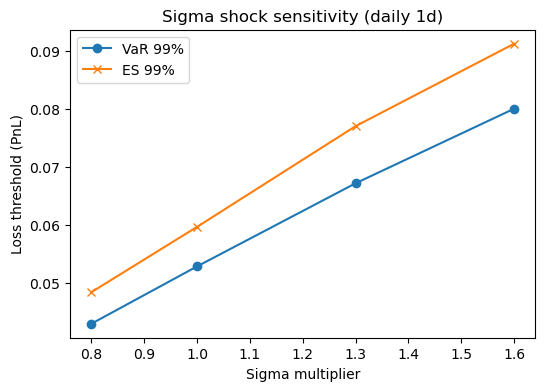

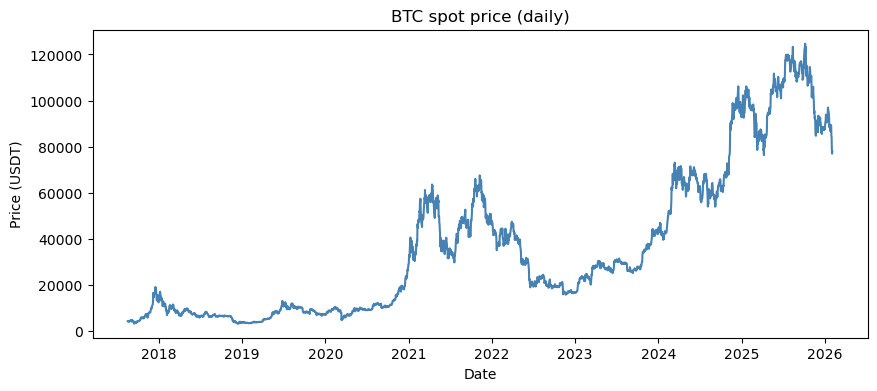

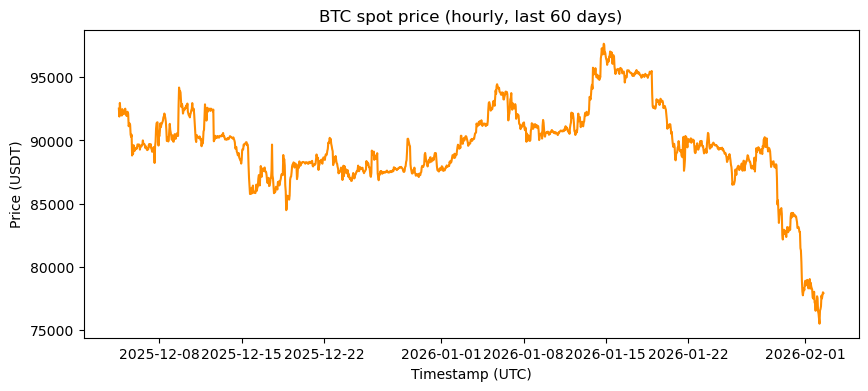

In [74]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily["date"], daily["price"], color="steelblue")
ax.set_title("BTC spot price (daily)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USDT)")
savefig(fig, "btc_price_daily.png")
plt.show()

# Hourly sample: last 60 days for readability
sample_end = hourly["timestamp"].max()
sample_start = sample_end - pd.Timedelta(days=60)
hourly_sample = hourly[hourly["timestamp"] >= sample_start]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hourly_sample["timestamp"], hourly_sample["price"], color="darkorange")
ax.set_title("BTC spot price (hourly, last 60 days)")
ax.set_xlabel("Timestamp (UTC)")
ax.set_ylabel("Price (USDT)")
savefig(fig, "btc_price_hourly_sample.png")
plt.show()

## 2) Volatility instability (daily + hourly)


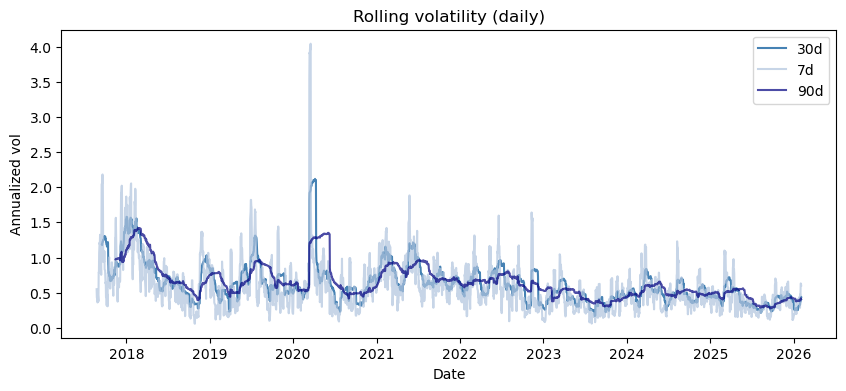

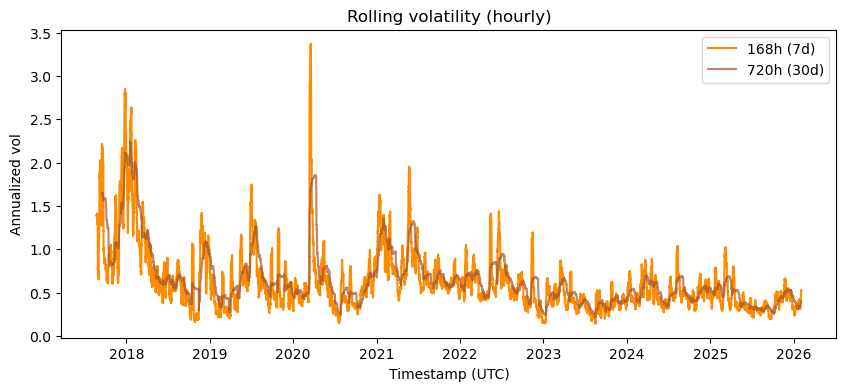

In [75]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily["date"], daily["vol_30d"], label="30d", color="steelblue")
ax.plot(daily["date"], daily["vol_7d"], label="7d", color="lightsteelblue", alpha=0.7)
ax.plot(daily["date"], daily["vol_90d"], label="90d", color="navy", alpha=0.7)
ax.set_title("Rolling volatility (daily)")
ax.set_xlabel("Date")
ax.set_ylabel("Annualized vol")
ax.legend()
savefig(fig, "btc_rolling_vol_daily.png")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hourly["timestamp"], hourly["vol_168h"], label="168h (7d)", color="darkorange")
ax.plot(hourly["timestamp"], hourly["vol_720h"], label="720h (30d)", color="sienna", alpha=0.7)
ax.set_title("Rolling volatility (hourly)")
ax.set_xlabel("Timestamp (UTC)")
ax.set_ylabel("Annualized vol")
ax.legend()
savefig(fig, "btc_rolling_vol_hourly.png")
plt.show()

We avoid absolute Δvol here because hourly volatility moves are naturally larger in scale. 
Instead we plot a *scale-free* change in realized volatility (relative change; log-change is computed but not shown) 
so daily and hourly instability can be compared on the same axis.


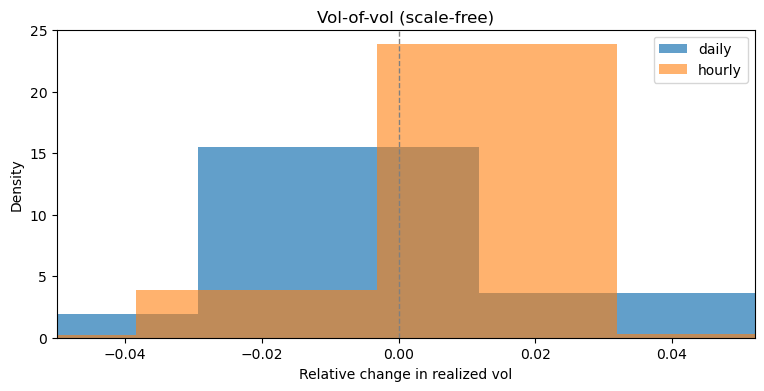

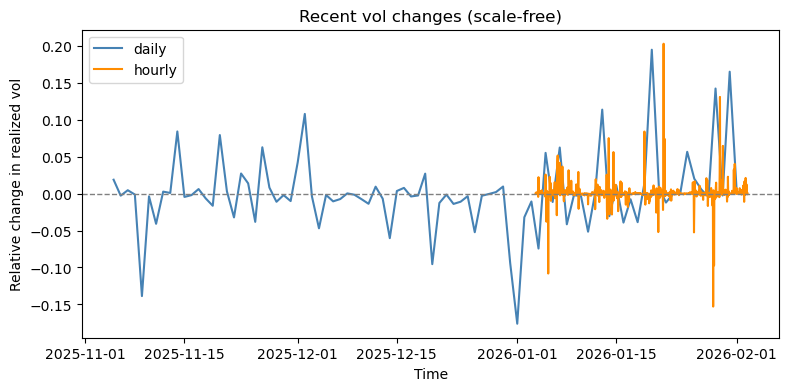

In [76]:
# Scale-free vol-of-vol metric (relative change by default)
daily_vol = daily["vol_30d"]
hourly_vol = hourly["vol_168h"]

daily_rel = (daily_vol - daily_vol.shift(1)) / daily_vol.shift(1)
hourly_rel = (hourly_vol - hourly_vol.shift(1)) / hourly_vol.shift(1)

daily_log = np.log(daily_vol) - np.log(daily_vol.shift(1))
hourly_log = np.log(hourly_vol) - np.log(hourly_vol.shift(1))


def clean_series(series: pd.Series) -> pd.Series:
    series = series.replace([np.inf, -np.inf], np.nan)
    return series.dropna()


daily_rel = clean_series(daily_rel[daily_vol.shift(1) > 0])
hourly_rel = clean_series(hourly_rel[hourly_vol.shift(1) > 0])
daily_log = clean_series(daily_log[daily_vol.shift(1) > 0])
hourly_log = clean_series(hourly_log[hourly_vol.shift(1) > 0])

metric_label = "Relative change in realized vol"
daily_metric = daily_rel
hourly_metric = hourly_rel

combined = pd.concat([daily_metric, hourly_metric])
x_low, x_high = combined.quantile([0.01, 0.99]).tolist()

# Figure 1: histogram comparison
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(daily_metric, bins=60, density=True, alpha=0.7, label="daily")
ax.hist(hourly_metric, bins=60, density=True, alpha=0.6, label="hourly")
ax.axvline(0.0, color="gray", linestyle="--", linewidth=1)
ax.set_xlim(x_low, x_high)
ax.set_title("Vol-of-vol (scale-free)")
ax.set_xlabel(metric_label)
ax.set_ylabel("Density")
ax.legend()
savefig(fig, "vol_of_vol_instability_hist.png")
plt.show()

# Figure 2: recent time-series clustering
daily_recent = daily_metric.tail(90)
hourly_recent = hourly_metric.tail(24 * 30)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(
    daily["date"].iloc[-len(daily_recent) :], daily_recent.values, label="daily", color="steelblue"
)
ax.plot(
    hourly["timestamp"].iloc[-len(hourly_recent) :],
    hourly_recent.values,
    label="hourly",
    color="darkorange",
)
ax.axhline(0.0, color="gray", linestyle="--", linewidth=1)
ax.set_title("Recent vol changes (scale-free)")
ax.set_xlabel("Time")
ax.set_ylabel(metric_label)
ax.legend()
savefig(fig, "vol_of_vol_instability_timeseries.png")
plt.show()

## 3) Tail mismatch vs Normal baseline (daily)


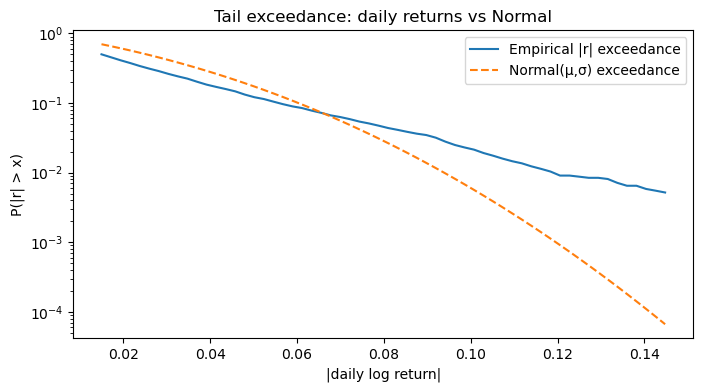

In [ ]:
from math import erf, sqrt

daily_returns = daily["ret_1d"].dropna()
mu = daily_returns.mean()
sigma = daily_returns.std()

x_grid = np.linspace(daily_returns.abs().quantile(0.5), daily_returns.abs().quantile(0.995), 60)
emp_exceed = [(np.abs(daily_returns) > x).mean() for x in x_grid]


def normal_cdf(x: float) -> float:
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))


normal_exceed = []
for x in x_grid:
    z = (x - mu) / sigma
    p = 1.0 - normal_cdf(z)
    normal_exceed.append(2.0 * p)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_grid, emp_exceed, label="Empirical |r| exceedance")
ax.plot(x_grid, normal_exceed, label="Normal(μ,σ) exceedance", linestyle="--")
ax.set_yscale("log")
ax.set_title("Tail exceedance: daily returns vs Normal")
ax.set_xlabel("|daily log return|")
ax.set_ylabel("P(|r| > x)")
ax.legend()
savefig(fig, "tail_exceedance_daily_vs_normal.png")
plt.show()

## 4) Rolling calibration (no look-ahead)


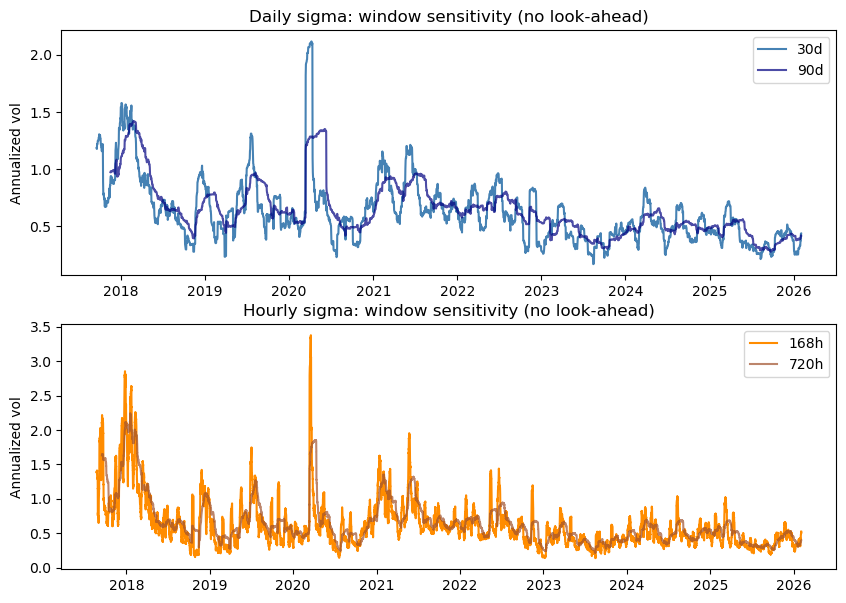

In [78]:
daily_ret = daily["ret_1d"]
hourly_ret = hourly["ret_1h"]

daily_sigma_short = daily_ret.shift(1).rolling(DAILY_WINDOWS[0]).std() * np.sqrt(365.0)
daily_sigma_long = daily_ret.shift(1).rolling(DAILY_WINDOWS[1]).std() * np.sqrt(365.0)

hourly_sigma_short = hourly_ret.shift(1).rolling(HOURLY_WINDOWS[0]).std() * np.sqrt(24.0 * 365.0)
hourly_sigma_long = hourly_ret.shift(1).rolling(HOURLY_WINDOWS[1]).std() * np.sqrt(24.0 * 365.0)

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
axes[0].plot(daily["date"], daily_sigma_short, label=f"{DAILY_WINDOWS[0]}d", color="steelblue")
axes[0].plot(daily["date"], daily_sigma_long, label=f"{DAILY_WINDOWS[1]}d", color="navy", alpha=0.7)
axes[0].set_title("Daily sigma: window sensitivity (no look-ahead)")
axes[0].set_ylabel("Annualized vol")
axes[0].legend()

axes[1].plot(
    hourly["timestamp"], hourly_sigma_short, label=f"{HOURLY_WINDOWS[0]}h", color="darkorange"
)
axes[1].plot(
    hourly["timestamp"], hourly_sigma_long, label=f"{HOURLY_WINDOWS[1]}h", color="sienna", alpha=0.7
)
axes[1].set_title("Hourly sigma: window sensitivity (no look-ahead)")
axes[1].set_ylabel("Annualized vol")
axes[1].legend()

savefig(fig, "sigma_calibration_window_comparison.png")
plt.show()

## 5) Short-horizon risk via Monte Carlo under calibrated σ


In [79]:
# Choose evaluation indices where both short and long sigmas are available
daily_valid = daily_sigma_long.dropna().index
hourly_valid = hourly_sigma_long.dropna().index

daily_eval_idx = pick_eval_indices(daily_valid, N_EVAL_DATES)
hourly_eval_idx = pick_eval_indices(hourly_valid, N_EVAL_DATES)

daily_eval_dates = daily.loc[daily_eval_idx, "date"].tolist()
hourly_eval_dates = hourly.loc[hourly_eval_idx, "timestamp"].tolist()

daily_results = []
for i, idx in enumerate(daily_eval_idx):
    sigma_short = float(daily_sigma_short.loc[idx])
    sigma_long = float(daily_sigma_long.loc[idx])
    for horizon_days, n_steps in [(1, 1), (5, 5)]:
        T = horizon_days / 365.0
        for label, sigma_use in [("short", sigma_short), ("long", sigma_long)]:
            for alpha in ALPHAS:
                var, es = simulate_var_es_gbm(
                    sigma_use,
                    T,
                    n_steps,
                    N_PATHS,
                    SEED_BASE + i * 100 + horizon_days * 10 + int(alpha * 100),
                    alpha,
                )
                daily_results.append(
                    {
                        "date": daily.loc[idx, "date"],
                        "horizon_days": horizon_days,
                        "window": label,
                        "alpha": alpha,
                        "var": var,
                        "es": es,
                    }
                )

daily_results = pd.DataFrame(daily_results)

hourly_results = []
for i, idx in enumerate(hourly_eval_idx):
    sigma_short = float(hourly_sigma_short.loc[idx])
    sigma_long = float(hourly_sigma_long.loc[idx])
    for horizon_hours, n_steps in [(24, 24), (168, 168)]:
        T = horizon_hours / (24.0 * 365.0)
        for label, sigma_use in [("short", sigma_short), ("long", sigma_long)]:
            for alpha in ALPHAS:
                var, es = simulate_var_es_gbm(
                    sigma_use,
                    T,
                    n_steps,
                    N_PATHS,
                    SEED_BASE + i * 100 + horizon_hours + int(alpha * 100),
                    alpha,
                )
                hourly_results.append(
                    {
                        "timestamp": hourly.loc[idx, "timestamp"],
                        "horizon_hours": horizon_hours,
                        "window": label,
                        "alpha": alpha,
                        "var": var,
                        "es": es,
                    }
                )

hourly_results = pd.DataFrame(hourly_results)
daily_results.head()

,date,horizon_days,window,alpha,var,es
0,2017-11-16,1,short,0.95,0.077080,0.095716
1,2017-11-16,1,short,0.99,0.105671,0.119472
2,2017-11-16,1,long,0.95,0.082208,0.101985
3,2017-11-16,1,long,0.99,0.112553,0.127169
4,2017-11-16,5,short,0.95,0.163667,0.201467


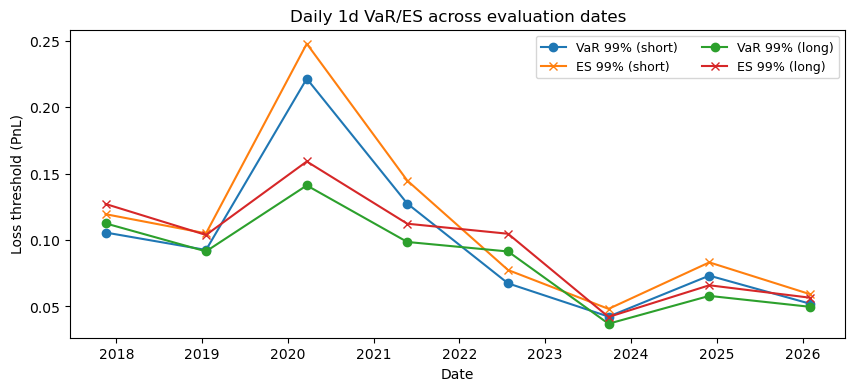

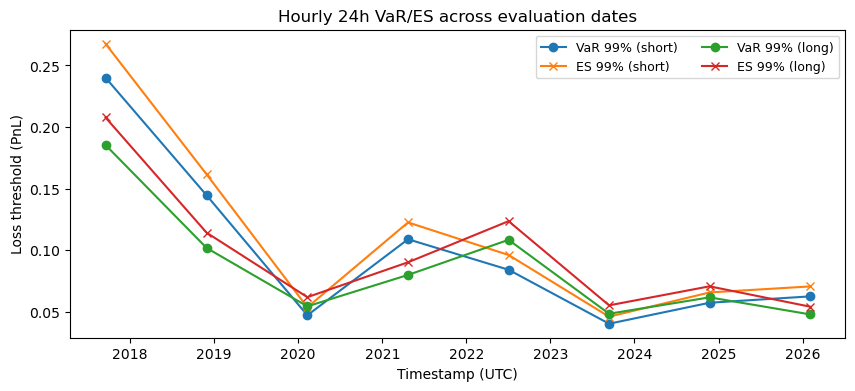

In [80]:
# Plot daily 1d VaR/ES (alpha=0.99) across evaluation dates
daily_plot = daily_results[(daily_results["horizon_days"] == 1) & (daily_results["alpha"] == 0.99)]

fig, ax = plt.subplots(figsize=(10, 4))
for label in ["short", "long"]:
    subset = daily_plot[daily_plot["window"] == label]
    ax.plot(subset["date"], subset["var"], marker="o", label=f"VaR 99% ({label})")
    ax.plot(subset["date"], subset["es"], marker="x", label=f"ES 99% ({label})")

ax.set_title("Daily 1d VaR/ES across evaluation dates")
ax.set_xlabel("Date")
ax.set_ylabel("Loss threshold (PnL)")
ax.legend(ncol=2, fontsize=9)
savefig(fig, "var_es_across_dates_daily.png")
plt.show()

# Plot hourly 24h VaR/ES (alpha=0.99) across evaluation dates
hourly_plot = hourly_results[
    (hourly_results["horizon_hours"] == 24) & (hourly_results["alpha"] == 0.99)
]

fig, ax = plt.subplots(figsize=(10, 4))
for label in ["short", "long"]:
    subset = hourly_plot[hourly_plot["window"] == label]
    ax.plot(subset["timestamp"], subset["var"], marker="o", label=f"VaR 99% ({label})")
    ax.plot(subset["timestamp"], subset["es"], marker="x", label=f"ES 99% ({label})")

ax.set_title("Hourly 24h VaR/ES across evaluation dates")
ax.set_xlabel("Timestamp (UTC)")
ax.set_ylabel("Loss threshold (PnL)")
ax.legend(ncol=2, fontsize=9)
savefig(fig, "var_es_across_dates_hourly.png")
plt.show()

### Optional: light coverage check for 1d VaR (99%)


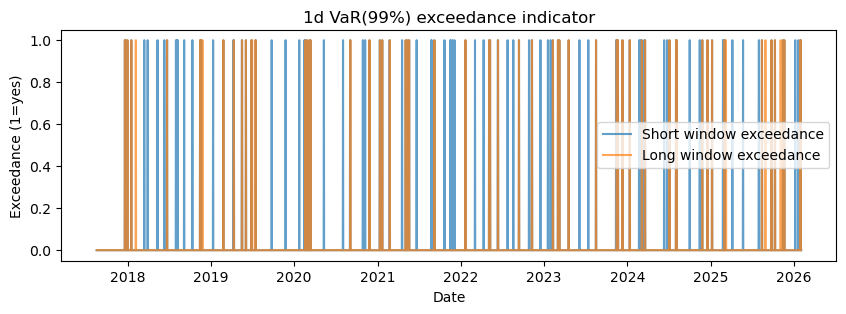

In [81]:
daily_var_short = []
daily_var_long = []
daily_realized = daily["ret_1d"]

for i in range(len(daily)):
    if i < DAILY_WINDOWS[1]:
        daily_var_short.append(np.nan)
        daily_var_long.append(np.nan)
        continue
    short_window = daily["ret_1d"].iloc[i - DAILY_WINDOWS[0] : i]
    long_window = daily["ret_1d"].iloc[i - DAILY_WINDOWS[1] : i]
    daily_var_short.append(empirical_var(short_window.dropna().values, alpha=0.99))
    daily_var_long.append(empirical_var(long_window.dropna().values, alpha=0.99))

daily_var_short = pd.Series(daily_var_short, index=daily.index)
daily_var_long = pd.Series(daily_var_long, index=daily.index)

exceed_short = daily_realized < -daily_var_short
exceed_long = daily_realized < -daily_var_long

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(daily["date"], exceed_short.astype(int), label="Short window exceedance", alpha=0.7)
ax.plot(daily["date"], exceed_long.astype(int), label="Long window exceedance", alpha=0.7)
ax.set_title("1d VaR(99%) exceedance indicator")
ax.set_xlabel("Date")
ax.set_ylabel("Exceedance (1=yes)")
ax.legend()
savefig(fig, "var_coverage_exceedances.png")
plt.show()

## 6) Empirical vs MC tail risk (model mismatch)


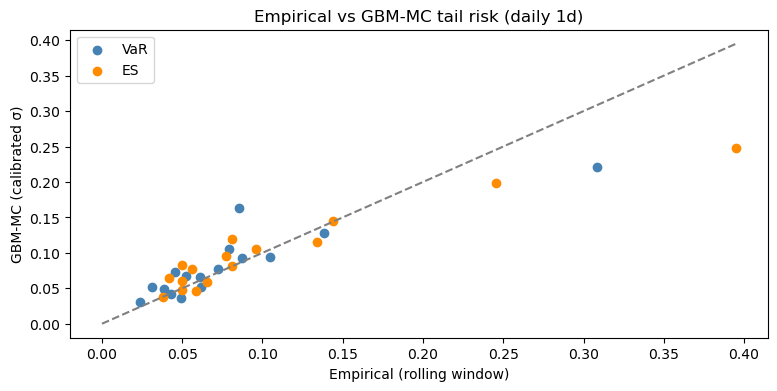

In [82]:
empirical_records = []

for i, idx in enumerate(daily_eval_idx):
    pnl = horizon_pnl_samples(
        daily["ret_1d"],
        end_idx=idx,
        window=DAILY_WINDOWS[0],
        horizon=1,
    )
    if pnl is None:
        continue
    for alpha in ALPHAS:
        empirical_records.append(
            {
                "date": daily.loc[idx, "date"],
                "alpha": alpha,
                "var_emp": empirical_var(pnl, alpha=alpha),
                "es_emp": empirical_es(pnl, alpha=alpha),
            }
        )

empirical_daily = pd.DataFrame(empirical_records)

mc_daily = daily_results[
    (daily_results["horizon_days"] == 1) & (daily_results["window"] == "short")
]

compare = mc_daily.merge(empirical_daily, on=["date", "alpha"], how="inner")

fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(compare["var_emp"], compare["var"], label="VaR", color="steelblue")
ax.scatter(compare["es_emp"], compare["es"], label="ES", color="darkorange")
max_val = max(
    compare["var_emp"].max(), compare["var"].max(), compare["es_emp"].max(), compare["es"].max()
)
ax.plot([0, max_val], [0, max_val], color="gray", linestyle="--")
ax.set_title("Empirical vs GBM-MC tail risk (daily 1d)")
ax.set_xlabel("Empirical (rolling window)")
ax.set_ylabel("GBM-MC (calibrated σ)")
ax.legend()
savefig(fig, "empirical_vs_mc_var_es.png")
plt.show()

## 7) Optional: sigma shock sensitivity


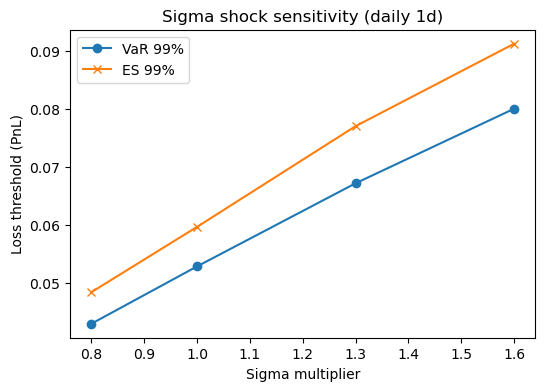

In [83]:
if daily_eval_idx:
    idx = daily_eval_idx[-1]
    sigma_base = float(daily_sigma_short.loc[idx])
    multipliers = [0.8, 1.0, 1.3, 1.6]
    rows = []
    for m in multipliers:
        sigma_use = sigma_base * m
        var, es = simulate_var_es_gbm(
            sigma_use,
            horizon_years=1 / 365.0,
            n_steps=1,
            n_paths=N_PATHS,
            seed=SEED_BASE + int(m * 100),
            alpha=0.99,
        )
        rows.append({"multiplier": m, "var": var, "es": es})

    shock_df = pd.DataFrame(rows)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(shock_df["multiplier"], shock_df["var"], marker="o", label="VaR 99%")
    ax.plot(shock_df["multiplier"], shock_df["es"], marker="x", label="ES 99%")
    ax.set_title("Sigma shock sensitivity (daily 1d)")
    ax.set_xlabel("Sigma multiplier")
    ax.set_ylabel("Loss threshold (PnL)")
    ax.legend()
    savefig(fig, "var_es_sigma_shock_sensitivity.png")
plt.show()

## 8) Interpretation & limitations

**Key takeaways (diagnostic, not predictive):**
- BTC volatility is unstable across time and across calibration windows.
- Tail exceedance probabilities are materially higher than a Normal/GBM baseline.
- Short-horizon VaR/ES estimates depend heavily on the chosen window and horizon.
- Empirical tails can exceed GBM-MC estimates, highlighting model risk.

**Limitations:**
- Single asset, single exchange, no microstructure modeling.
- No regime-switching or stochastic volatility model.
- The GBM baseline is deliberately simplistic.
- This is a stress/diagnostic workflow, not a trading system.
